![Vidi_Waterflux_Banner](https://raw.githubusercontent.com/ITC-Water-Resources/Vidi-waterflux-merch/refs/heads/main/jupyter/Vidi_Waterflux_Banner.png)
*Roelof Rietbroek, Sedigheh Karimi, Amin Shakya EGU 2025*

# Create spherical harmonic coefficients for the relevant basins, and compute the associated sea level responses

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import geopandas as gpd
import shxarray
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#local python tools
from common.config import read_config

In [3]:
shxengine='shtns' #requires shtns backend but is much quicker
nmax=300
conf=read_config()
datadir=conf['dataroot']


In [4]:
basinsgpkg=os.path.join(datadir,'hydroshed_csl03_gl_l021.gpkg')

gdfbasins=gpd.read_file(basinsgpkg)

gdfbasins.head()

,PFAF_ID,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,ENDO,COAST,ORDER,SORT,name,geometry
0,111,1030000010,0,1030000010,1030000010,0.0,0.0,236343.2,236343.2,0,1,0,1,SETIT,"MULTIPOLYGON (((39.76528 15.42917, 39.75492 15..."
1,112,1030003990,0,1030003990,1030003990,0.0,0.0,519027.5,519027.5,0,1,0,2,GULF OF ADEN/SOMALIA,"MULTIPOLYGON (((40.81528 14.75417, 40.79561 14..."
2,114,1030008100,0,1030008100,1030008100,0.0,0.0,797881.4,797881.4,0,0,1,3,SHEBELLE,"MULTIPOLYGON (((36.74167 4.06667, 36.74131 4.0..."
3,117,1030008110,0,1030008110,1030008110,0.0,0.0,1040194.7,1040194.7,0,1,0,4,RUFIJI,"MULTIPOLYGON (((40.84444 -2.43333, 40.83833 -2..."
4,122,1030011660,0,1030011660,1030011660,0.0,0.0,1378103.3,1378121.1,0,0,1,6,ZAMBEZI,"MULTIPOLYGON (((35.2625 -18.23333, 35.26215 -1..."


In [11]:
#Convert to spherical harmonics
dbasins_sh=xr.DataArray.sh.from_geoseries(gdfbasins.geometry,nmax,auxcoord=gdfbasins.name,engine=shxengine)
dbasins_sh.name='basins'
display(dbasins_sh)



shxarray-INFO: Masking and gridding polygons
shxarray-INFO: Applying SH analysis


<xarray.DataArray 'basins' (name: 124, nm: 90601)> Size: 90MB
array([[ 4.67155721e-04,  4.50576181e-04,  2.79101075e-04, ...,
        -1.22487597e-08,  5.34087354e-09,  1.67106718e-09],
       [ 9.95285262e-04,  1.24095001e-03,  2.54781007e-04, ...,
         6.88946979e-06, -1.53689235e-05, -1.89362638e-05],
       [ 1.55033108e-03,  1.76372889e-03,  1.93507773e-04, ...,
        -2.19382474e-06,  6.74174186e-05,  1.33737188e-05],
       ...,
       [ 4.53385911e-03,  5.27524861e-03,  5.40705165e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.80618953e-03,  3.40975763e-03,  3.35741112e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.17184848e-03,  1.69395257e-03,  1.10839981e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(124, 90601))
Coordinates:
  * nm       (nm) object 725kB MultiIndex
  * n        (nm) int64 725kB 0 1 1 1 2 2 2 2 ... 300 300 300 300 300 300 300
  * m        (nm) int64 725kB 0 -1 0 1 -2 -1 0 1 ... 294 295 296 297 298 299 300
  * name     (name) object 992B 'SETIT' ... 'TIBETAN PLATEAU'
Attributes:
    Conventions:  CF-1.8
    source:       shxarray-1.3.1.dev0+gc9b9093.d20250313 <https://github.com/...
    contact:      Roelof Rietbroek <r.rietbroek@utwente.nl>
    institution:  ITC Faculty of Geo-Information Science and Earth Observatio...
    comments:     Used backend: SHTns High performance Spherical Harmonic Tra...
    history:      Analysis operation

In [12]:
dbasins_sh.sel(n=0,m=0)

<xarray.DataArray 'basins' (name: 124)> Size: 992B
array([4.67155721e-04, 9.95285262e-04, 1.55033108e-03, 2.03948599e-03,
       2.71985587e-03, 4.90232661e-04, 8.04364978e-04, 8.11148329e-04,
       2.37450957e-04, 1.91145354e-03, 4.84081353e-04, 1.00676087e-03,
       7.28158711e-03, 1.29099859e-03, 5.71027604e-05, 4.14794433e-03,
       3.57078807e-04, 7.88797557e-04, 1.63946165e-03, 9.08841628e-04,
       1.61425487e-03, 5.14607295e-04, 5.33373430e-04, 4.23545747e-05,
       5.98907488e-03, 3.51671919e-05, 1.16425764e-03, 2.22372012e-03,
       1.70601530e-03, 2.65209587e-03, 2.20710840e-03, 1.80520563e-03,
       1.15187510e-03, 5.15847823e-04, 1.55966036e-03, 4.79947775e-03,
       1.46084757e-04, 6.64099729e-04, 6.94509519e-04, 2.13905312e-04,
       8.49157645e-04, 1.41318531e-04, 1.02369445e-03, 3.05412107e-04,
       1.57525844e-03, 6.53777424e-05, 5.79857048e-04, 3.44975138e-04,
       1.52330864e-04, 6.03113248e-04, 7.75089972e-04, 1.63160871e-03,
       1.44512008e-04, 1.35364165e-03, 1.02038196e-03, 9.24258752e-04,
       4.86258243e-04, 6.59969385e-04, 1.93120557e-03, 3.92913854e-05,
       5.18393978e-05, 6.22629133e-05, 4.59444277e-04, 1.70930732e-04,
       1.93823593e-04, 1.31381793e-04, 3.02177979e-05, 1.53065860e-04,
       1.35954568e-03, 1.45392211e-03, 2.76736371e-03, 1.08768167e-03,
       6.59925395e-04, 1.84333518e-03, 6.54019992e-04, 1.09484999e-03,
       2.45774696e-03, 1.09933907e-03, 1.60755446e-03, 1.07615854e-03,
       4.42620491e-04, 4.20896552e-03, 4.95254618e-03, 2.69674430e-03,
       4.34933530e-03, 5.67198284e-03, 2.12584272e-03, 6.59627689e-03,
       4.38484507e-03, 4.51965738e-04, 4.15657645e-03, 1.35159766e-02,
       4.14904290e-03, 7.09897384e-03, 2.96629421e-03, 2.14057051e-03,
       9.52683337e-04, 7.11382228e-03, 5.14042285e-03, 2.29911873e-03,
       4.88351292e-03, 5.32601631e-03, 5.97430939e-04, 1.45159488e-03,
       2.44085633e-03, 1.95522689e-03, 1.50885728e-02, 5.27673467e-04,
       3.54635381e-03, 3.89677080e-03, 2.13359984e-03, 2.02973902e-04,
       7.24508263e-04, 1.08167002e-03, 8.63132735e-04, 5.94354742e-03,
       8.72110359e-03, 4.44519146e-03, 9.27271742e-03, 8.90613228e-04,
       3.09016912e-03, 4.53385911e-03, 2.80618953e-03, 1.17184848e-03])
Coordinates:
    nm       object 8B (np.int64(0), np.int64(0))
    n        int64 8B 0
    m        int64 8B 0
  * name     (name) object 992B 'SETIT' ... 'TIBETAN PLATEAU'
Attributes:
    Conventions:  CF-1.8
    source:       shxarray-1.3.1.dev0+gc9b9093.d20250313 <https://github.com/...
    contact:      Roelof Rietbroek <r.rietbroek@utwente.nl>
    institution:  ITC Faculty of Geo-Information Science and Earth Observatio...
    comments:     Used backend: SHTns High performance Spherical Harmonic Tra...
    history:      Analysis operation

Text(0.5, 1.0, 'BANDAMA')

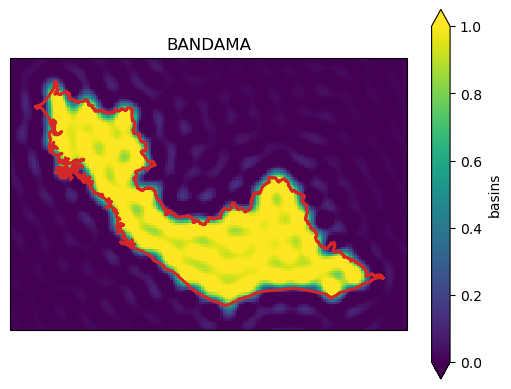

In [16]:
#quick visual check

basin='BANDAMA'
# basin='SHEBELLE'

gdfbasin=gdfbasins.loc[gdfbasins.name==basin]
lonmin,latmin,lonmax,latmax=gdfbasin.geometry.bounds.iloc[0]
res=0.125
margin=10*res
dbasin_grd=dbasins_sh.sel(name=basin).sh.synthesis(lon=np.arange(lonmin-margin,lonmax+margin,res),lat=np.arange(latmin-margin,latmax+margin,res))
ax = plt.axes(projection=ccrs.PlateCarree())
dbasin_grd.plot(ax=ax,vmax=1,vmin=0,transform=ccrs.PlateCarree())
ax.add_geometries(gdfbasin.geometry,edgecolor='tab:red',crs=ccrs.PlateCarree(),facecolor="none",lw=2)
ax.set_title(basin)

In [17]:
#save to netcdf for re-use
basinsshout=os.path.join(datadir,conf['ncbasin'])
dbasins_sh.reset_index('nm').to_netcdf(basinsshout)